Start with basic package imports

In [18]:
import xarray as xr
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# key definitions are in a separte file
from WeatherTyping import loop_kmeans, get_number_eof, get_classifiability_index

import cartopy.crs as ccrs
from cartopy import feature
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Download Data

Download ERAi and re-forecast data. 5-day running average and naïve climatology/anomalies already computed using the IRI Data Library (see links for details) 

In [19]:
!mkdir -p data
!tree data

/bin/sh: tree: command not found


To download data from the IRI data library, you need an authentication key. This is stored in a file called `.IRIDLAUTH`, but is not part of the GitHub repository -- you need to contact the IRI Data Library to request access. Once you have done so, you can put your own authentication key in a file called `.IRIDLAUTH` and use this code. This is a moderately annoying step, and we apologize, but it is required by the S2S Database Terms and Conditions and is necessary for us to share all our code while maintaining some security.

**NB** if you're using `git`, be sure to add `.IRIDLAUTH` to your `gitignore` file :)

In [20]:
with open('.IRIDLAUTH') as file:
    authkey = file.read() 

Define a helper function to download data with a given URL

In [21]:
def download_data(url, authkey, outfile, force_download=False):
    """A smart function to download data from IRI Data Library
    If the data can be read in and force_download is False, will read from file
    Otherwise will download frim IRIDL and then read from file
    
    PARAMETERS
    ----------
        url: the url pointing to the data.nc file
        authkey: the authentication key for IRI DL (see above)
        outfile: the data filename
        force_download: False if it's OK to read from file, True if data *must* be re-downloaded
    """
    
    if not force_download:
        try:
            model = xr.open_dataset(outfile, decode_times=False)
        except:
            force_download = True
        
    if force_download:
        # calls curl to download data
        command = "curl -C - -k -b '__dlauth_id={}' '{}' > {}".format(authkey, url, outfile)
        get_ipython().system(command)
        # open the data
        model = xr.open_dataset(outfile, decode_times=False)
        
    return model

Now we can read the model data -- it will re-download the data if there is an issue reading it in, or if we set `force_download_model=True`

In [22]:
model = download_data(
    url='https://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/.ECMF/.reforecast/.perturbed/.pressure_level_gh/.gh/P/500/VALUE/P/removeGRID/S/(26%20Apr%202018)/VALUE/X/(-170)/(-30)/RANGE/Y/(20)/(80)/RANGE/hdate/(1998)/(2017)/RANGE/L/5/runningAverage/dup/%5Bhdate/M%5D/average/sub/S/removeGRID/data.nc', 
    outfile='data/hgt_ecmwf_prtb.nc', 
    authkey=authkey,
    force_download=False
).stack(time=['hdate', 'L'], grid=['X', 'Y'])
model['M'] = np.int_(model['M'])
print(model)

<xarray.Dataset>
Dimensions:  (M: 10, grid: 3990, time: 860)
Coordinates:
  * M        (M) int64 1 2 3 4 5 6 7 8 9 10
  * time     (time) MultiIndex
  - hdate    (time) float64 462.0 462.0 462.0 462.0 462.0 462.0 462.0 462.0 ...
  - L        (time) float64 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 ...
  * grid     (grid) MultiIndex
  - X        (grid) float64 -171.0 -171.0 -171.0 -171.0 -171.0 -171.0 -171.0 ...
  - Y        (grid) float64 19.5 21.0 22.5 24.0 25.5 27.0 28.5 30.0 31.5 ...
Data variables:
    gh       (M, time, grid) float64 7.767 1.977 -0.7635 -0.2446 2.737 9.391 ...


Same for the reanalysis data

In [23]:
reanalysis = download_data(
    url='https://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/.ECMF/.reforecast/.perturbed/.pressure_level_gh/.gh/P/500/VALUE/P/removeGRID/S/(26%20Apr%202018)/VALUE/X/(-170)/(-30)/RANGE/Y/(20)/(80)/RANGE/hdate/(1998)/(2017)/RANGE/hdate//pointwidth/0/def/-6/shiftGRID/hdate/(days%20since%201960-01-01)/streamgridunitconvert/S/(days%20since%202018-01-01)/streamgridunitconvert/S//units//days/def/L/0.5/add/hdate/add/add//pointwidth/1/def/home/.agmunoz/.ERAi/.6hr/.plev/.ERAi_6hrly_Z500.nc/.z/latitude/(Y)/renameGRID/longitude/(X)/renameGRID/time/(T)/renameGRID/T/3/shiftGRID/T/24/boxAverage/T/2/index/.units/streamgridunitconvert/exch/%5BT%5Dsample-along/c%3A/9.81/(m%20s-2)/%3Ac/div/S/removeGRID/L/5/runningAverage/%5BX/Y%5D/1.0/0./regridLinear/dup/%5Bhdate%5Daverage/2/RECHUNK/sub/data.nc',
    outfile='data/hgt_ecmwf_rean.nc', 
    authkey=authkey,
    force_download=False
).stack(time=['hdate', 'L'], grid=['X', 'Y'])
print(reanalysis)

<xarray.Dataset>
Dimensions:  (grid: 3990, time: 860)
Coordinates:
  * time     (time) MultiIndex
  - hdate    (time) float64 1.388e+04 1.388e+04 1.388e+04 1.388e+04 ...
  - L        (time) float64 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 ...
  * grid     (grid) MultiIndex
  - X        (grid) float64 -171.0 -171.0 -171.0 -171.0 -171.0 -171.0 -171.0 ...
  - Y        (grid) float64 19.5 21.0 22.5 24.0 25.5 27.0 28.5 30.0 31.5 ...
Data variables:
    ratio    (time, grid) float64 12.09 6.575 3.404 3.094 5.757 12.97 24.55 ...


# Dimension Reduction

We need tho choose a percentage of variance explained that we will require:

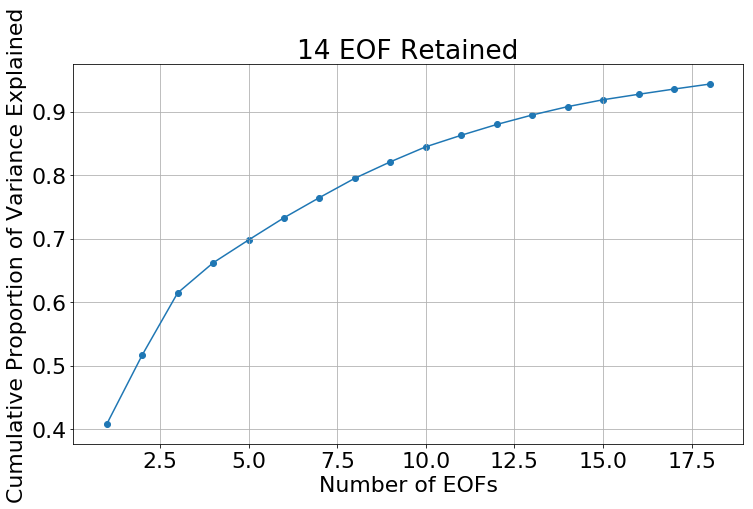

In [24]:
n_eof = get_number_eof(X=reanalysis['ratio'].values, var_to_explain=0.9, plot=True)

Now we project the data onto the leading EOFs to get the principal component time series.
We will retain the PCA model for use later.
The `reanalysis_pc` variable is now indexed [`time`, `EOF`].

In [8]:
pca_model = PCA(n_components=n_eof).fit(reanalysis['ratio'].values)
reanalysis_pc = pca_model.transform(reanalysis['ratio'].values)

# Reanalysis Weather Typing

Now we perform the clustering.
We will manually specify the number of clusters we want to create and the number of simulations we want to run.

In [9]:
ncluster = 4 # use 4 WTs
n_sim = 25 # typically several hundred -- this is for quick preliminary computation only

Now we can use this to run the classifiability index on our centroids

In [10]:
centroids, wtypes = loop_kmeans(X=reanalysis_pc, n_cluster=ncluster, n_sim=n_sim)
class_idx, best_part = get_classifiability_index(centroids)
print('The classifiability index is {}'.format(class_idx))

The classifiability index is 0.9991181553526277


Now that we have identified a suitable partition, we can use it to keep only the corresponding centroid and set of weather type labels.
To take advantage of the scikit-learn syntax, we then use these centroids to define a `KMeans` object.

In [11]:
best_fit = KMeans(n_clusters=ncluster, init=centroids[best_part, :, :], n_init=1, max_iter=1).fit(reanalysis_pc)

# Model Weather Types

Now, for each ensemble member, calculate the weather types by projecting the model geopotential height anomaly fields onto the reanalysis regimes and assigning each day of the forecast to the closest centroid in terms of Euclidean distance. The model anomaly fields are first calculated by first taking 5-day running averages and then subtracting the hindcast climatology on a daily basis. The anomalies are then projected into the reanalysis EOFs, and the distances then calculated in EOF space.

In [12]:
# start with reanalysis
reanalysis_composite = reanalysis.copy()
model_clust = best_fit.fit_predict(reanalysis_pc) # get centroids
weather_types = xr.DataArray(
    model_clust, 
    coords = {'time': reanalysis_composite['time']},
    dims='time'
)
reanalysis_composite['WT'] = weather_types
reanalysis_composite = reanalysis_composite.groupby('WT').mean(dim='time').unstack('grid')['ratio']
reanalysis_composite['M'] = 0

In [13]:
wt_anomalies = [] # initialize empty list
wt_anomalies.append(reanalysis_composite)
# loop through each model member
for m in model['M'].values:
    member_data = model['gh'].sel(M=m) # get subset of data
    member_pc_ts = pca_model.transform(member_data.values) # project leading EOFs onto reanalysis EOFs
    member_clust = best_fit.predict(member_pc_ts) # assign to nearest cluster (computed on reanalysis)
    member_clust = weather_types = xr.DataArray(
        model_clust, 
        coords = {'time': model['time']},
        dims='time'
    )
    member_data = member_data.unstack('grid') #
    member_data['WT'] = member_clust
    member_data = member_data.groupby('WT').mean(dim='time')
    wt_anomalies.append(member_data)
wt_anomalies = xr.concat(wt_anomalies, dim='M') # join together
wt_anomalies['WT'] = wt_anomalies['WT'] + 1 # start from 1

Plot as a function of WT and ensemble member.
Note `M=0` for reanalysis

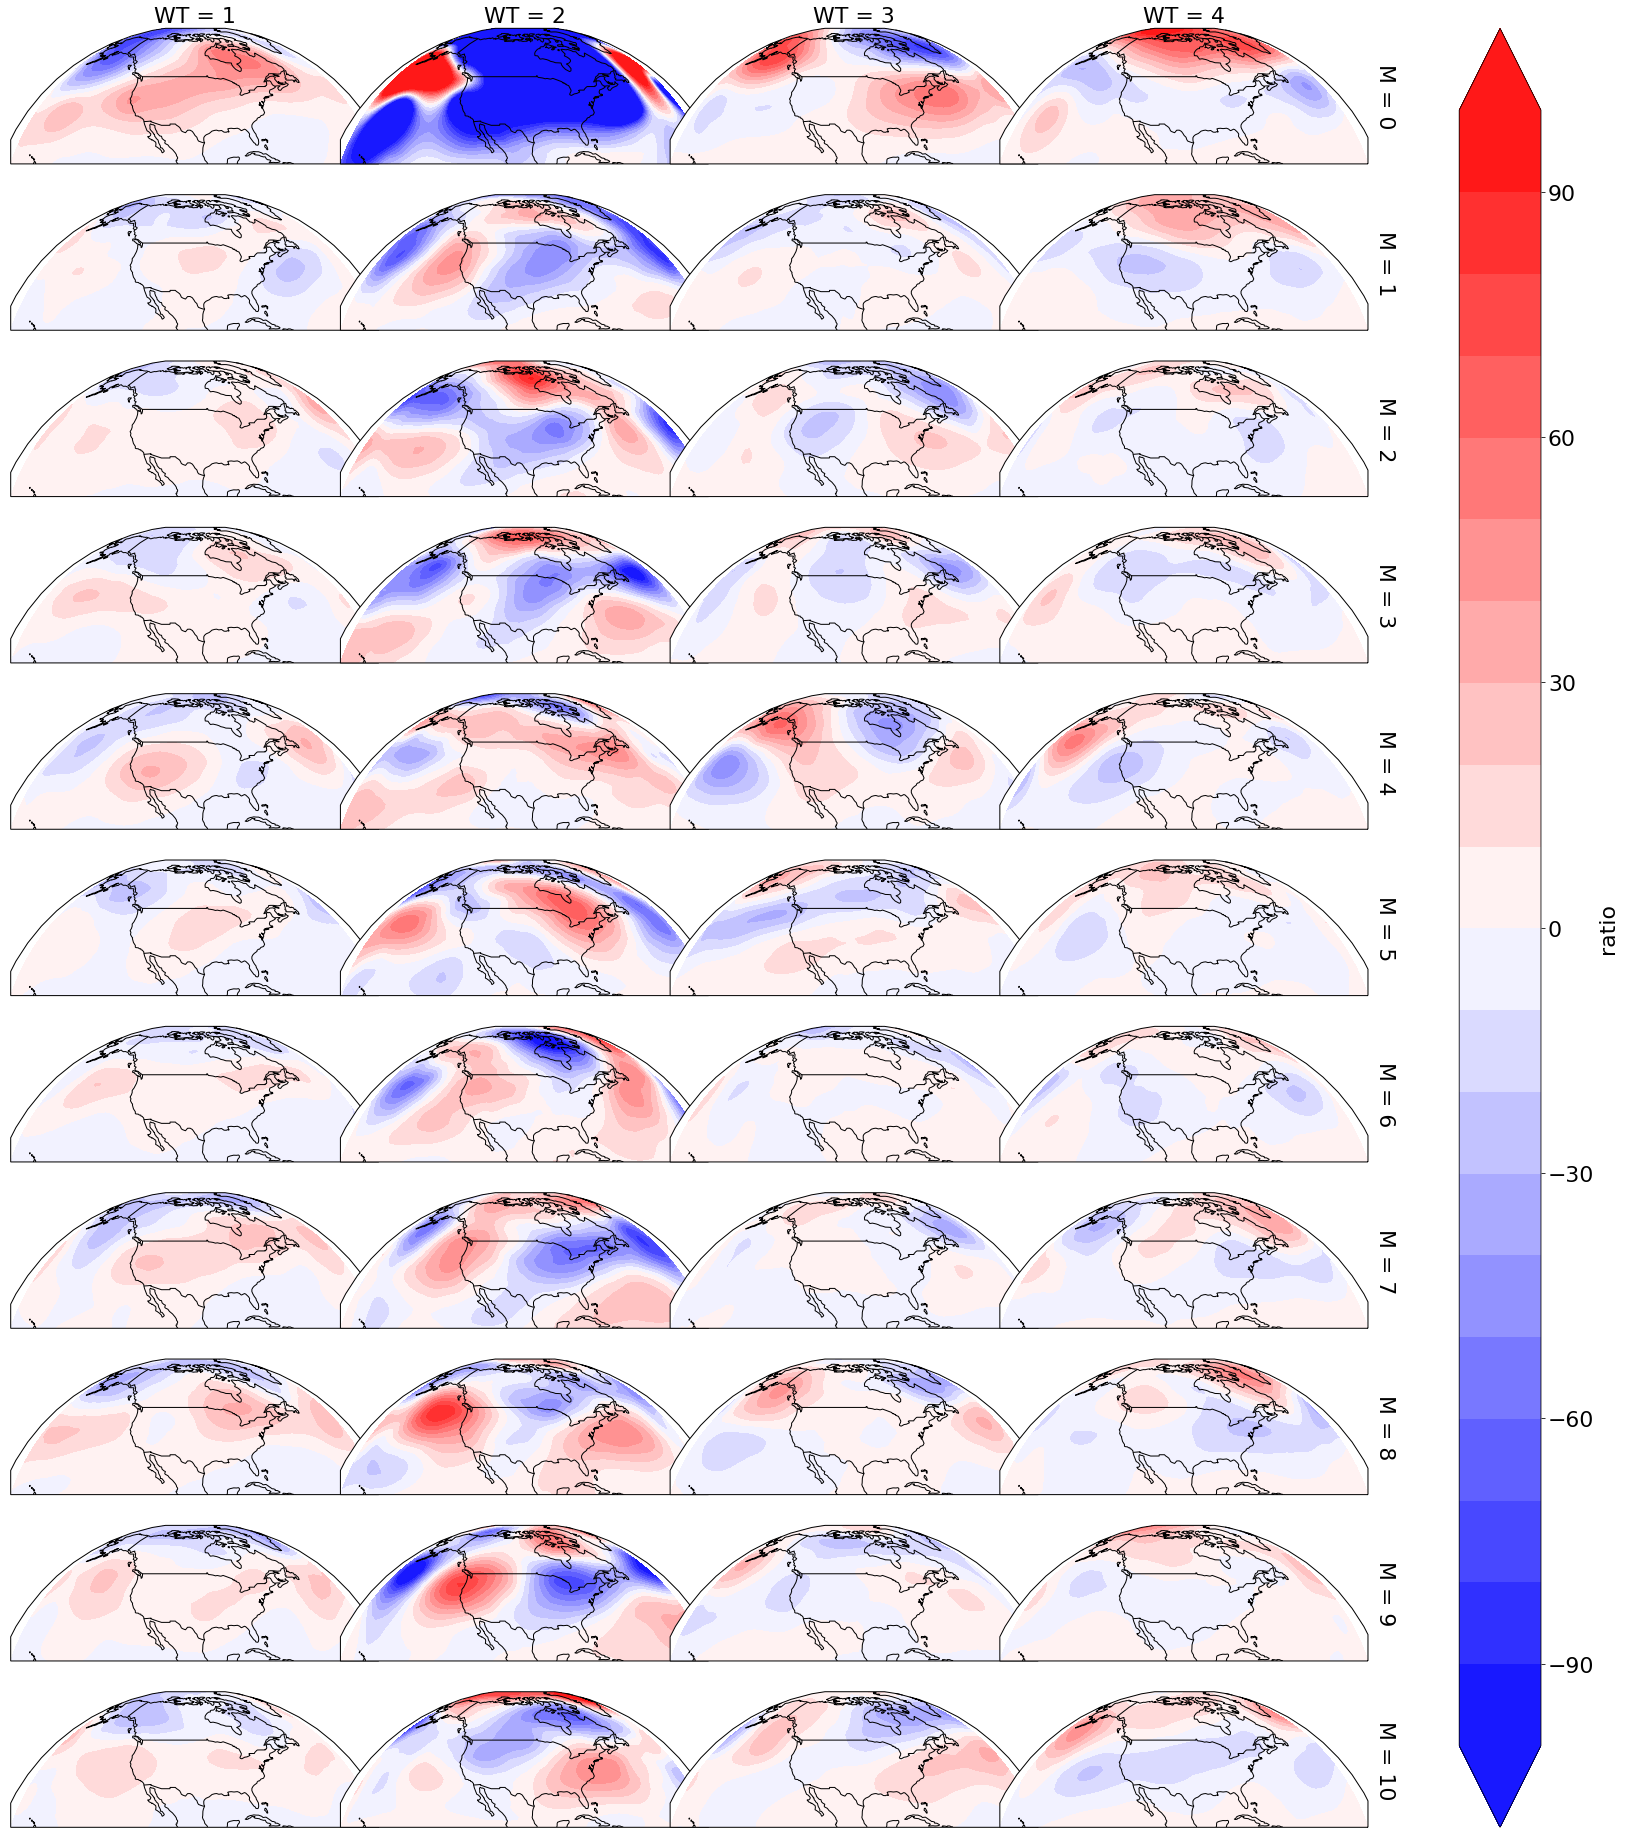

In [17]:
plt.rcParams.update({'font.size': 22})

p = wt_anomalies.plot.contourf(
    x='X', y='Y', col='WT', row='M',
    transform=ccrs.PlateCarree(),
    subplot_kws={
        'projection': ccrs.Orthographic(-100, 0)
        #ccrs.PlateCarree()
    },
    figsize=(26, 26),
    levels = np.linspace(-100, 100, 21),
    cmap=plt.cm.bwr,
    extend='both'
)

xmin,xmax = wt_anomalies['X'].min(), wt_anomalies['X'].max()
ymin,ymax = wt_anomalies['Y'].min(), wt_anomalies['Y'].max()
for ax in p.axes.flat:
    ax.coastlines()
    ax.add_feature(feature.BORDERS)
    ax.set_extent([xmin, xmax, ymin, ymax])

plt.show()